In [53]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Loading the dataset
# Reading the CSV file into a DataFrame
dataset_path = 'sentiment_analysis_dataset_1010_samples.csv'  # Update with your dataset path if necessary
data = pd.read_csv(dataset_path)

# Displaying the first few rows to inspect the dataset
print(data.head())

    ID                                             Review Sentiment  Length  \
0  822              Neutral feelings about this purchase.   Neutral       5   
1   93  Absolutely loved this product! Highly recommen...  Positive       7   
2  277  Absolutely loved this product! Highly recommen...  Positive       7   
3  926              The product is okay, nothing special.   Neutral       6   
4  155  Absolutely loved this product! Highly recommen...  Positive       7   

   PunctuationCount  UppercaseCount  SentimentScore     Source  ProductID  
0                 1               1               0  Website B       1081  
1                 2               2               1  Website A       1652  
2                 2               2               1  Website C       1843  
3                 2               1               0  Website C       1883  
4                 2               2               1  Website A       1082  


In [54]:
# Checking for missing values in the dataset
print("\nMissing Values in the Dataset:\n", data.isnull().sum())# Providing a summary of the dataset
print("\nDataset Overview:\n", data.info())
print("\nDataset Summary:\n", data.describe())


Missing Values in the Dataset:
 ID                  0
Review              0
Sentiment           0
Length              0
PunctuationCount    0
UppercaseCount      0
SentimentScore      0
Source              0
ProductID           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                1010 non-null   int64 
 1   Review            1010 non-null   object
 2   Sentiment         1010 non-null   object
 3   Length            1010 non-null   int64 
 4   PunctuationCount  1010 non-null   int64 
 5   UppercaseCount    1010 non-null   int64 
 6   SentimentScore    1010 non-null   int64 
 7   Source            1010 non-null   object
 8   ProductID         1010 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 71.1+ KB

Dataset Overview:
 None

Dataset Summary:
                 ID       Length  PunctuationCount

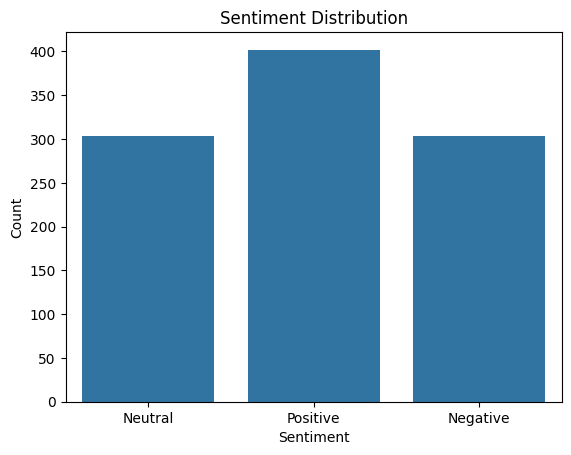

In [55]:
# Plotting the sentiment distribution
sns.countplot(data=data, x='Sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

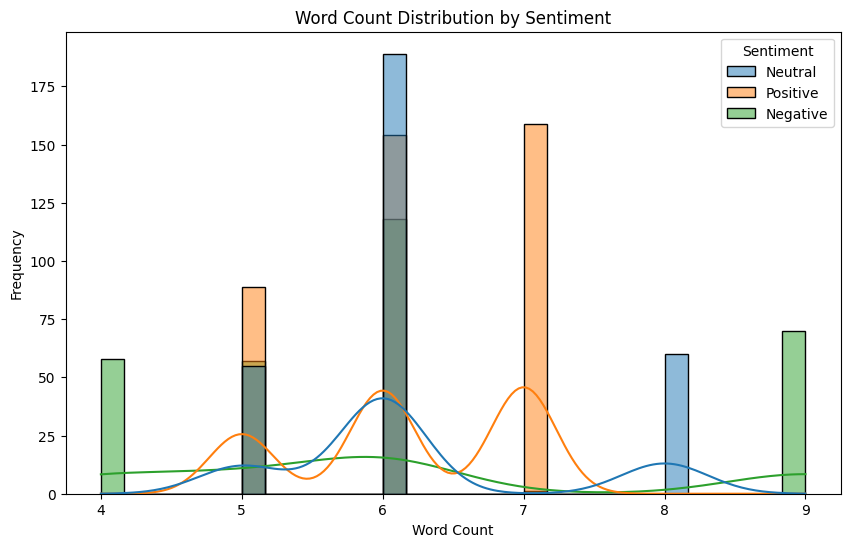

In [56]:
# Exploring text lengths
# Adding a column to calculate the number of words in each review
data['WordCount'] = data['Review'].apply(lambda x: len(x.split()))

# Adding a column for character count
data['CharCount'] = data['Review'].apply(len)

# Visualizing the distribution of word count
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='WordCount', hue='Sentiment', kde=True, bins=30)
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

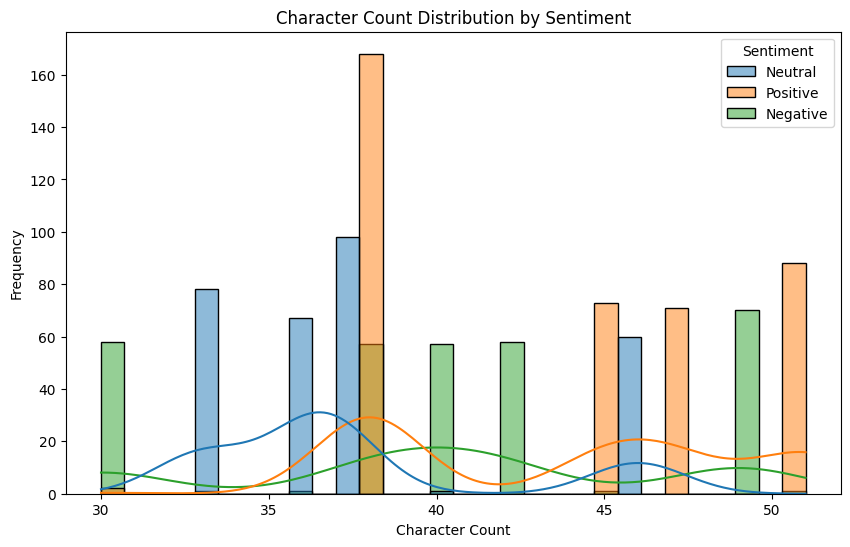

In [57]:
# Visualizing the distribution of character count
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='CharCount', hue='Sentiment', kde=True, bins=30)
plt.title('Character Count Distribution by Sentiment')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

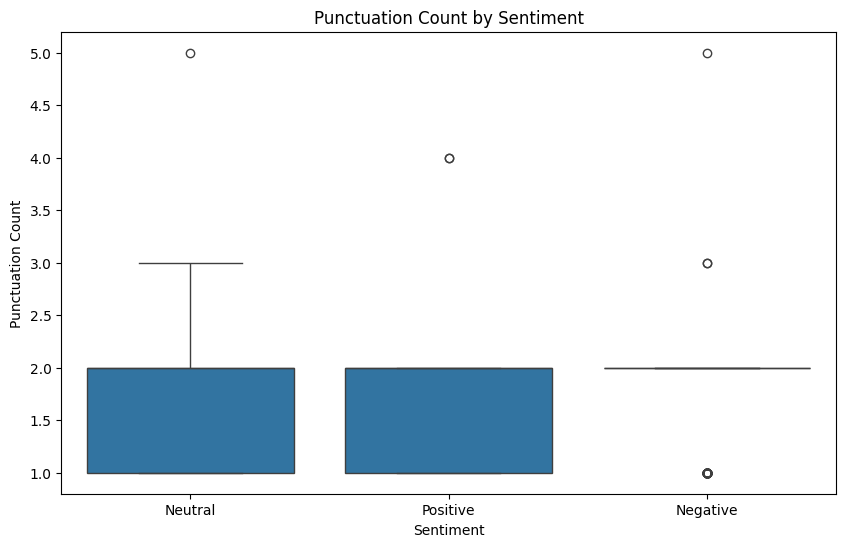

In [58]:
# Exploring punctuation usage
# Visualizing punctuation count distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Sentiment', y='PunctuationCount')
plt.title('Punctuation Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Punctuation Count')
plt.show()


Sentiment Proportion (%):
 Sentiment
Positive    39.80198
Neutral     30.09901
Negative    30.09901
Name: proportion, dtype: float64


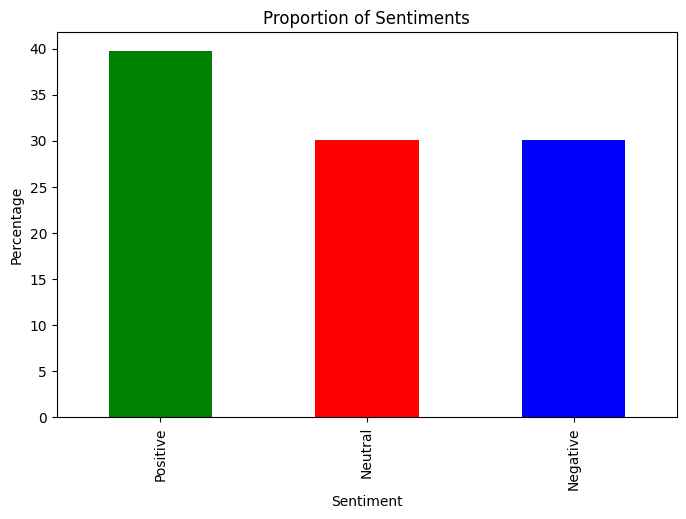

In [59]:
# Exploring the proportion of sentiments
sentiment_counts = data['Sentiment'].value_counts(normalize=True) * 100
print("\nSentiment Proportion (%):\n", sentiment_counts)

# Creating a bar plot for sentiment proportions
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Proportion of Sentiments')
plt.ylabel('Percentage')
plt.xlabel('Sentiment')
plt.show()

In [60]:
# Checking for class imbalance
print("\nClass Imbalance Check:\n")
print(data['Sentiment'].value_counts())


Class Imbalance Check:

Sentiment
Positive    402
Neutral     304
Negative    304
Name: count, dtype: int64


In [61]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Initializing stopwords, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Defining a function to preprocess the text
def preprocess_text(text):
    # Converting text to lowercase
    text = text.lower()
    
    # Tokenizing text
    tokens = word_tokenize(text)
    
    # Removing stopwords and non-alphanumeric tokens
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    
    # Applying stemming (or use lemmatization: lemmatizer.lemmatize(word))
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Joining tokens back into a single string
    return " ".join(tokens)

# Applying preprocessing to the 'Review' column
data['CleanedReview'] = data['Review'].apply(preprocess_text)

# Displaying the original and cleaned reviews for inspection
print(data[['Review', 'CleanedReview']].head())

                                              Review  \
0              Neutral feelings about this purchase.   
1  Absolutely loved this product! Highly recommen...   
2  Absolutely loved this product! Highly recommen...   
3              The product is okay, nothing special.   
4  Absolutely loved this product! Highly recommen...   

                           CleanedReview  
0                   neutral feel purchas  
1  absolut love product highli recommend  
2  absolut love product highli recommend  
3              product okay noth special  
4  absolut love product highli recommend  


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initializing TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2))  # Limiting to 500 features for efficiency

# Transforming the cleaned reviews into TF-IDF features
X = tfidf.fit_transform(data['CleanedReview']).toarray()

# Extracting target variable (sentiment labels)
y = data['Sentiment']

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Displaying shape of the feature and label sets
print("Training Features Shape:", X_train.shape)
print("Test Features Shape:", X_test.shape)
print("Training Labels Distribution:\n", y_train.value_counts())
print("Test Labels Distribution:\n", y_test.value_counts())

Training Features Shape: (808, 94)
Test Features Shape: (202, 94)
Training Labels Distribution:
 Sentiment
Positive    322
Negative    243
Neutral     243
Name: count, dtype: int64
Test Labels Distribution:
 Sentiment
Positive    80
Neutral     61
Negative    61
Name: count, dtype: int64


In [63]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Initializing Naïve Bayes model
nb_model = MultinomialNB()

# Training the model
nb_model.fit(X_train, y_train)

# Making predictions
y_pred_nb = nb_model.predict(X_test)

# Evaluating the model
print("Naïve Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Naïve Bayes Accuracy Score:", accuracy_score(y_test, y_pred_nb))

Naïve Bayes Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.97      0.98        61
     Neutral       0.98      1.00      0.99        61
    Positive       0.99      1.00      0.99        80

    accuracy                           0.99       202
   macro avg       0.99      0.99      0.99       202
weighted avg       0.99      0.99      0.99       202

Naïve Bayes Accuracy Score: 0.9900990099009901


In [64]:
from sklearn.svm import LinearSVC

# Initializing SVM model
svm_model = LinearSVC(random_state=42)

# Training the model
svm_model.fit(X_train, y_train)

# Making predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluating the model
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM Accuracy Score:", accuracy_score(y_test, y_pred_svm))

SVM Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.97      0.98        61
     Neutral       0.98      1.00      0.99        61
    Positive       0.99      1.00      0.99        80

    accuracy                           0.99       202
   macro avg       0.99      0.99      0.99       202
weighted avg       0.99      0.99      0.99       202

SVM Accuracy Score: 0.9900990099009901


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


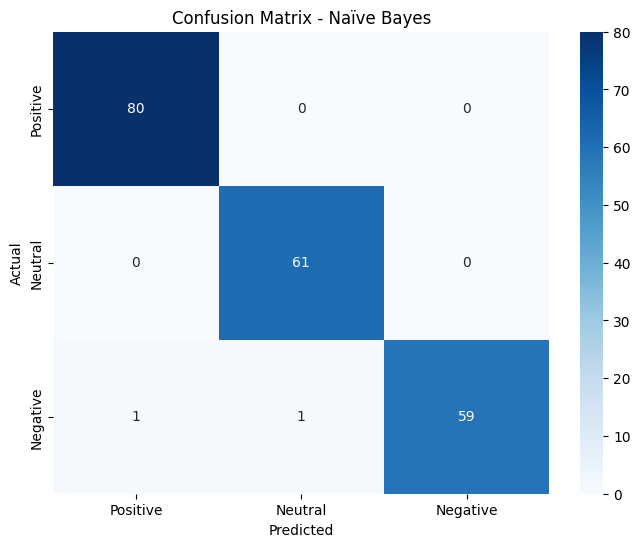

In [65]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=["Positive", "Neutral", "Negative"])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Positive", "Neutral", "Negative"], yticklabels=["Positive", "Neutral", "Negative"])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Confusion matrix for Naïve Bayes
plot_confusion_matrix(y_test, y_pred_nb, "Confusion Matrix - Naïve Bayes")

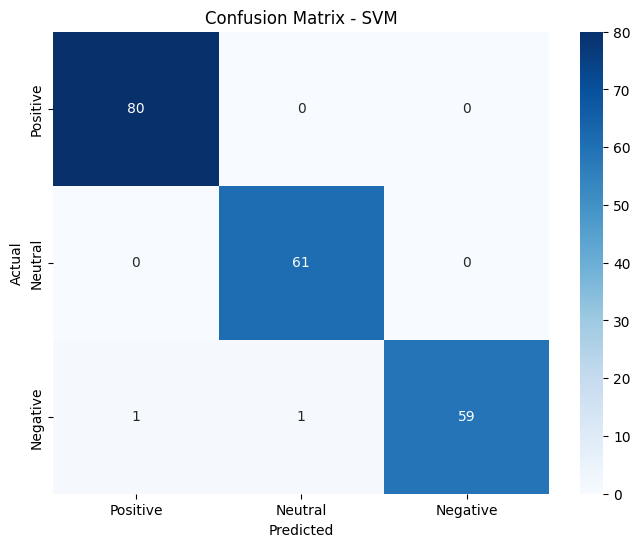

In [66]:
# Confusion matrix for SVM
plot_confusion_matrix(y_test, y_pred_svm, "Confusion Matrix - SVM")

In [67]:
# Comparing accuracy scores
print("\nComparison of Model Performance:")
print(f"Naïve Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.2f}")
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")


Comparison of Model Performance:
Naïve Bayes Accuracy: 0.99
SVM Accuracy: 0.99


In [68]:
# Downloading the VADER lexicon
import nltk
nltk.download('vader_lexicon')

# Initializing VADER SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbookairm1/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [69]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initializing VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to analyze sentiment using VADER
def vader_sentiment(review):
    scores = sia.polarity_scores(review)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Applying VADER sentiment analysis to the 'Review' column
data['VADER_Sentiment'] = data['Review'].apply(vader_sentiment)

# Comparing VADER results with true sentiments
comparison_df = data[['Sentiment', 'VADER_Sentiment']]

# Displaying first few rows of the comparison
print(comparison_df.head())

# Evaluating VADER performance
from sklearn.metrics import accuracy_score, classification_report

vader_accuracy = accuracy_score(data['Sentiment'], data['VADER_Sentiment'])
print("\nVADER Sentiment Analysis Accuracy:", vader_accuracy)
print("\nVADER Classification Report:\n", classification_report(data['Sentiment'], data['VADER_Sentiment']))

  Sentiment VADER_Sentiment
0   Neutral         Neutral
1  Positive        Positive
2  Positive        Positive
3   Neutral        Negative
4  Positive        Positive

VADER Sentiment Analysis Accuracy: 0.6118811881188119

VADER Classification Report:
               precision    recall  f1-score   support

    Negative       0.59      0.80      0.68       304
     Neutral       0.28      0.18      0.22       304
    Positive       0.80      0.80      0.80       402

    accuracy                           0.61      1010
   macro avg       0.55      0.59      0.56      1010
weighted avg       0.58      0.61      0.59      1010



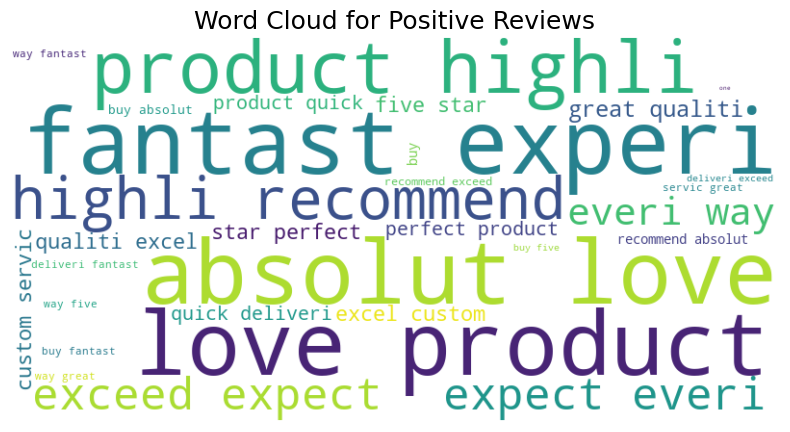

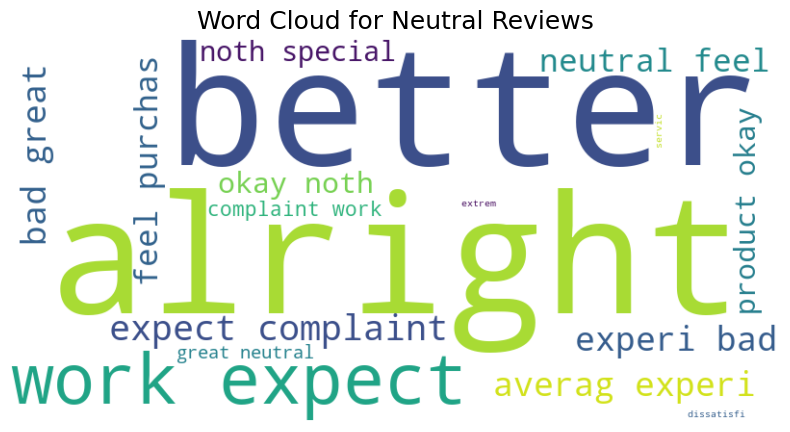

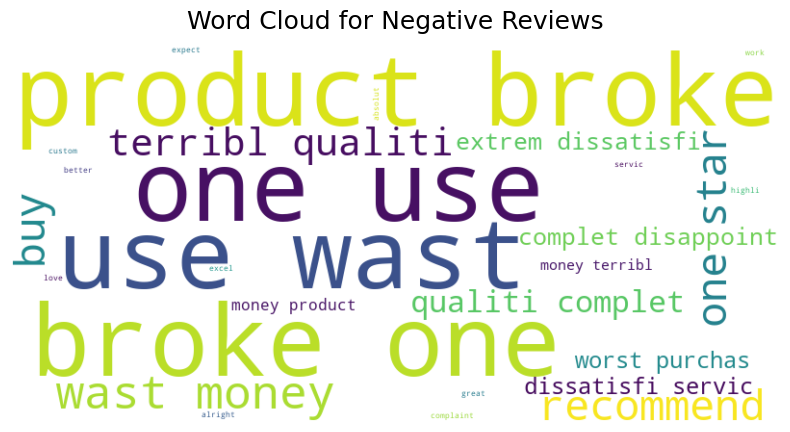

In [70]:
from wordcloud import WordCloud

# Function to generate a Word Cloud
def generate_wordcloud(sentiment, title):
    # Filtering reviews based on sentiment
    text = " ".join(data[data['Sentiment'] == sentiment]['CleanedReview'])
    
    # Creating a WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plotting the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18)
    plt.axis('off')
    plt.show()

# Generating Word Clouds for each sentiment
generate_wordcloud('Positive', "Word Cloud for Positive Reviews")
generate_wordcloud('Neutral', "Word Cloud for Neutral Reviews")
generate_wordcloud('Negative', "Word Cloud for Negative Reviews")